### Очистить датасет от пропусков и ошибок

In [1]:
import pandas as pd
data= pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

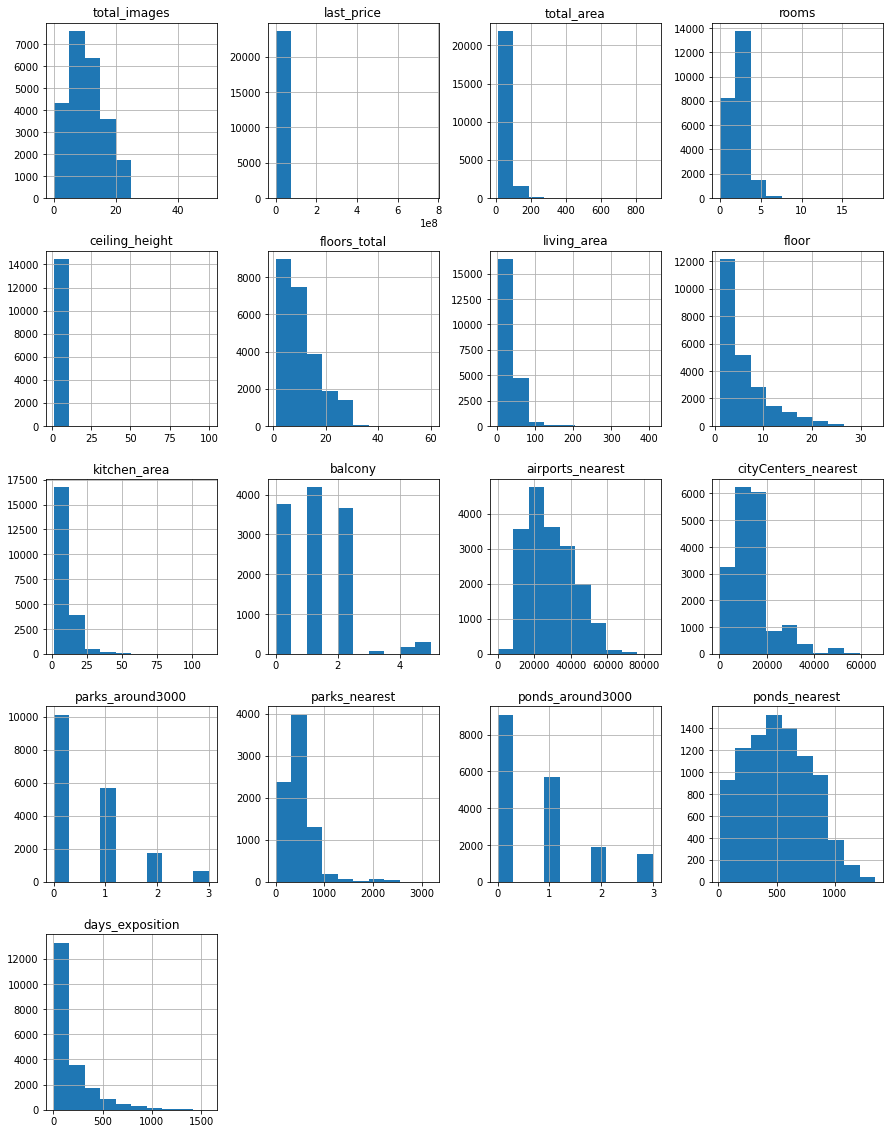

In [4]:
#data.info()
data.hist(figsize=(15, 20));

In [5]:
data.isnull().sum()  #проверим общее количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

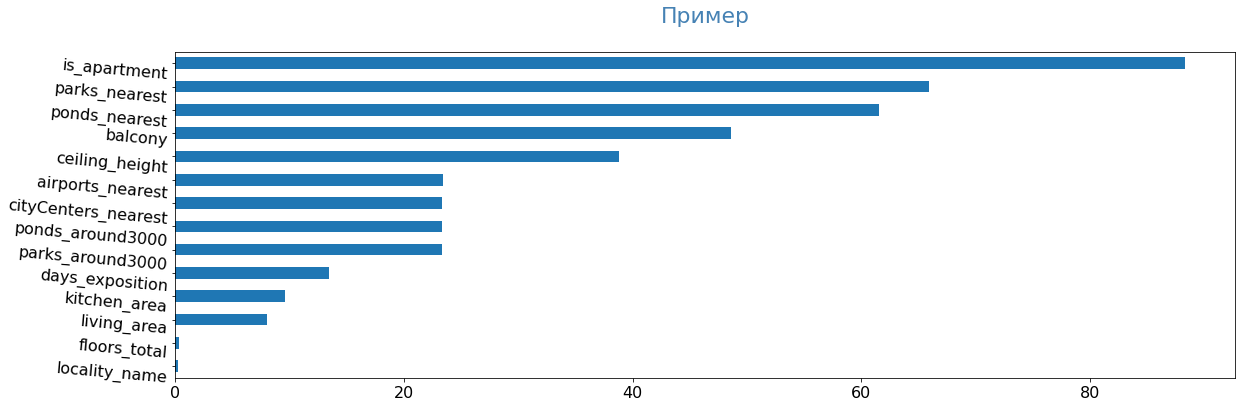

In [7]:
pass_value_barh(data)

### Подготовить данные для анализа

In [8]:
data.rename(columns= {'cityCenters_nearest' : 'city_centers_nearest'}, inplace = True) # приведем к единому стилю
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Определим важные данные:
 - Пропуски в балкона сворее всего являються техническими, приведем их к 0
 - Прощадь кухни и жилой комнаты, заполним по медиане
 - В высоте потолка допущена техническая ошибка, исправим ее
 - Что делать с апартаментами?
 - Локальное имя и общяя этажность, можно пожертвовать

In [9]:
#data['balcony'].unique()
data['balcony'].fillna(0, inplace=True)
data['balcony'].astype(int).value_counts()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

In [10]:
#data.groupby('rooms')['living_area'].agg(['median','mean']) #проверяю медиану

#for t in data['rooms'].unique():
#    data.loc[(data['rooms'] == t) & (data['living_area'].isna()), 'living_area'] = \
#    data.loc[(data['rooms'] == t), 'living_area'].median()
    
    
#data['living_area'].isnull().sum() #проверка

In [11]:
#for q in data['rooms'].unique():
#    data.loc[(data['rooms'] == q) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
#    data.loc[(data['rooms'] == q), 'kitchen_area'].median()
    
#data['kitchen_area'].isnull().sum() #проверка   

In [12]:
data.query('total_area <= (living_area + kitchen_area)').shape[0]
# кажеться есть проблемы в росчетах...

134

In [13]:
# Число квартир с rooms = 0
data.query('rooms == 0 & kitchen_area == 0').shape[0]
# Проверим, что множества квартир со свободной планировкой и студий не пересекаются
#data.query('studio == True & open_plan == True').shape[0]


0

In [14]:
# Сгруппируем датасет по количеству комнат
grouped_by_rooms = data.groupby('rooms')

# Создадим два новых столбца: с отношением жилой площади к общей, а также с отношением площади кухни к общей
data['living_to_total_ratio'] = data['living_area'] / data['total_area']
#data['kitchen_to_total_ratio'] = data['kitchen_area'] / data['total_area']

# Заполним пропуски в `living_to_total_ratio` и `kitchen_to_total_ratio` медианным отношением в зависимости от числа комнат
data['living_to_total_ratio'] = data['living_to_total_ratio'].fillna(grouped_by_rooms['living_to_total_ratio'].transform('median'))
#data['kitchen_to_total_ratio'] = data['kitchen_to_total_ratio'].fillna(grouped_by_rooms['kitchen_to_total_ratio'].transform('median'))

# Заполним пропуски в `living_area` и `kitchen_area`, пользуясь известным отношением
data['living_area'] = data['living_area'].fillna(data['total_area'] * data['living_to_total_ratio'])
#data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * data['kitchen_to_total_ratio'])

In [15]:
for q in data['kitchen_area'].isnull():
    data['kitchen_area'] = (data['total_area'] - data['living_area']) * 0.9
data['kitchen_area'].isnull().sum() #проверка   

0

In [16]:
data['rooms'].corr(data['living_area'])
#

0.8258183012276648

In [17]:
data.isnull().sum()

total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            9195
floors_total                86
living_area                  0
floor                        0
is_apartment             20924
studio                       0
open_plan                    0
kitchen_area                 0
balcony                      0
locality_name               49
airports_nearest          5542
city_centers_nearest      5519
parks_around3000          5518
parks_nearest            15620
ponds_around3000          5518
ponds_nearest            14589
days_exposition           3181
living_to_total_ratio        0
dtype: int64

In [18]:
# check

data[data['total_area']*0.9 <= (data ['living_area']+data ['kitchen_area'])][['total_area'
                                                                                  ,'living_area','kitchen_area']]

,total_area,living_area,kitchen_area
0,108.00,51.000000,51.300000
1,40.40,18.600000,19.620000
2,56.00,34.300000,19.530000
3,159.00,100.435000,52.708500
4,100.00,32.000000,61.200000
...,...,...,...
23694,133.81,73.300000,54.459000
23695,59.00,38.000000,18.900000
23696,56.70,29.700000,24.300000
23697,76.75,44.899452,28.665494


In [19]:
# Потолки выше 8 метром, кажетутся черезмерными, перезаполним их медианой
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()
data['ceiling_height'].astype(int)
data.loc[(data.ceiling_height > 5.0) | (data.ceiling_height < 2), 'ceiling_height'] = data['ceiling_height'].median()

In [20]:
data['ceiling_height'].unique()

array([2.7 , 2.65, 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 ,
       2.55, 3.  , 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57, 4.15,
       3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 2.34, 3.4 , 3.06,
       2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 2.87, 2.66, 2.59,
       2.  , 2.45, 3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.16, 3.62,
       3.12, 2.53, 2.74, 2.96, 2.46, 5.  , 2.79, 2.95, 4.06, 2.94, 3.82,
       3.54, 3.53, 2.83, 4.7 , 2.4 , 3.38, 3.01, 3.65, 3.9 , 3.18, 3.35,
       2.3 , 3.57, 2.48, 2.62, 2.82, 3.98, 2.63, 3.83, 3.52, 3.95, 3.75,
       2.88, 3.67, 3.87, 3.66, 3.85, 3.86, 4.19, 3.24, 4.8 , 4.5 , 4.2 ,
       3.36, 3.08, 3.68, 3.07, 3.37, 3.09, 3.26, 3.34, 2.81, 3.44, 2.97,
       3.14, 4.37, 2.68, 3.22, 3.27, 4.1 , 2.93, 3.46, 3.47, 3.33, 3.63,
       3.32, 2.98, 2.86, 3.17, 4.4 , 3.28, 3.04, 4.45, 3.84, 3.23, 3.02,
       3.21, 3.43, 3.78, 4.3 , 3.39, 2.69, 3.31, 4.65, 3.56, 2.2 , 3.51,
       3.93, 3.42, 2.99, 3.49, 4.14, 2.91, 3.88, 4.

Исторически высота потолков в нашей стране сокращалась. Так, в дореволюционных жилых домах (1890–1930 гг.), в "сталинках" (1930–1950 гг.) высота потолков была значительно выше 3,2–5 м. А вот в домах постройки 1950–1980 гг., так называемых хрущевках, средняя высота потолков не превышала 2,4–2,5 м, вспоминает заместитель генерального директора "Главстрой–СПб" Александр Лелин.

отбросим все выбивающиеся значения, заполним их по медиане

In [21]:
#data['ceiling_height'].where((data.ceiling_height > 5.0, data.ceiling_height<2), other=data['ceiling_height'].median(), inplace=True)

In [22]:
data['locality_name'].unique()
#len(data['locality_name'].unique())  # ответ 365

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [23]:
#замена "ё" на "е"
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

#уберем из названий "поселок городского типа", "городской", "коттеджный"  
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок', regex=True)

len(data['locality_name'].unique()) # после удаление неявныъ дубликатов

321

- Всего 44 дубля, не самый сильные результат ) но теперь их нет

In [24]:
#удалим строки, где не указано название города и этажность здания, их количество (86+49) позволяет пренебречь этими данными

data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)

print('Количество пропусков в столбце с названиями городов:', data['locality_name'].isna().sum())
print('Количество пропусков в столбце с общей этажностью:', data['floors_total'].isna().sum())

Количество пропусков в столбце с названиями городов: 0
Количество пропусков в столбце с общей этажностью: 0


In [25]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           23565 non-null  int64  
 1   last_price             23565 non-null  float64
 2   total_area             23565 non-null  float64
 3   first_day_exposition   23565 non-null  object 
 4   rooms                  23565 non-null  int64  
 5   ceiling_height         23565 non-null  float64
 6   floors_total           23565 non-null  float64
 7   living_area            23565 non-null  float64
 8   floor                  23565 non-null  int64  
 9   is_apartment           2760 non-null   object 
 10  studio                 23565 non-null  bool   
 11  open_plan              23565 non-null  bool   
 12  kitchen_area           23565 non-null  float64
 13  balcony                23565 non-null  float64
 14  locality_name          23565 non-null  object 
 15  ai

In [26]:
data.dropna(subset=['floors_total'], inplace=True)
data['floors_total'].fillna(0, inplace=True)
data['floors_total'].astype(int)

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23565, dtype: int64

In [27]:
data.query('total_area == 0').shape[0] # проверяем, что у нас нет квартир с 0 прощадью

0

In [28]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,565.00","23,565.00","23,565.00","20,394.00","23,565.00","23,565.00","23,565.00","23,565.00","23,565.00"
min,0.00,12.00,2.00,1.00,"12,190.00",2.00,0.00,1.00,1.00
max,19.00,900.00,5.00,"1,580.00","763,000,000.00",430.13,441.27,33.00,60.00


In [29]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8004
2,7897
3,5779
4,1172
5,325
0,194
6,104
7,59
8,12
9,8


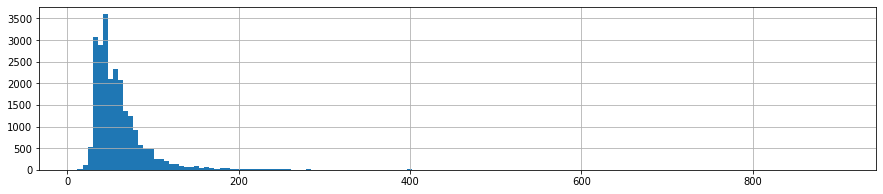

In [30]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

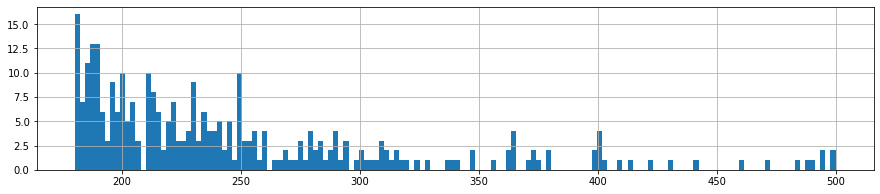

In [31]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [32]:
# Вставил обрезку, что б избавить от выбрасов
data = data.loc[(data.total_area < 200) & (data.rooms < 9) & (data.floors_total < 30)]

In [33]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,301.00","23,301.00","23,301.00","20,190.00","23,301.00","23,301.00","23,301.00","23,301.00","23,301.00"
min,0.00,12.00,2.00,1.00,"12,190.00",2.00,0.00,1.00,1.00
max,8.00,199.20,5.00,"1,580.00","330,000,000.00",164.70,132.30,27.00,29.00


In [34]:
data['price_metr'] = data['last_price']/data['total_area'] # Добавляем цену за метр

#Приведем дату и время, к условиям задания
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['day_of_the_week_exp'] = data['first_day_exposition'].dt.weekday
data['month_exp'] = data['first_day_exposition'].dt.month_name()
data['year_exp'] = data['first_day_exposition'].dt.year


# Сгруппируем этажи по 3 типам
def floor_function (row_values):
    
        if row_values['floor']==1:
            return 'первый'
        elif row_values['floor']==row_values['floors_total']:
            return'последний'
        else:
            return 'другой'
        
data['floor_group'] = data.apply(floor_function,axis=1)           


data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_to_total_ratio,price_metr,day_of_the_week_exp,month_exp,year_exp,floor_group
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,482.0,2.0,755.0,NaN,0.472222,120370.370370,3,March,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,NaN,0.0,NaN,81.0,0.460396,82920.792079,1,December,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,90.0,2.0,574.0,558.0,0.612500,92785.714286,3,August,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,100.435000,9,NaN,...,84.0,3.0,234.0,424.0,0.631667,408176.100629,4,July,2015,другой
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,112.0,1.0,48.0,121.0,0.320000,100000.000000,1,June,2018,другой
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,NaN,...,NaN,NaN,NaN,55.0,0.473684,95065.789474,0,September,2018,другой
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,NaN,...,NaN,0.0,NaN,155.0,0.284182,99195.710456,3,November,2017,другой
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,41.886654,22,NaN,...,NaN,0.0,NaN,NaN,0.585009,110544.692737,3,April,2019,другой
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.430000,26,NaN,...,NaN,NaN,NaN,189.0,0.465320,87454.764777,2,May,2018,другой
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,NaN,...,NaN,0.0,NaN,289.0,0.714754,88524.590164,6,February,2017,другой


In [35]:

data['city_centers_1km'] = data['city_centers_nearest'] / 1000
data['city_centers_1km'] = data.replace(pd.NA, np.nan).round()

data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,living_to_total_ratio,price_metr,day_of_the_week_exp,month_exp,year_exp,floor_group,city_centers_1km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,2.0,755.0,NaN,0.472222,120370.370370,3,March,2019,другой,20
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,0.0,NaN,81.0,0.460396,82920.792079,1,December,2018,первый,7
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,2.0,574.0,558.0,0.612500,92785.714286,3,August,2015,другой,10
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,100.435000,9,NaN,...,3.0,234.0,424.0,0.631667,408176.100629,4,July,2015,другой,0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,1.0,48.0,121.0,0.320000,100000.000000,1,June,2018,другой,2
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,NaN,...,NaN,NaN,55.0,0.473684,95065.789474,0,September,2018,другой,10
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,NaN,...,0.0,NaN,155.0,0.284182,99195.710456,3,November,2017,другой,6
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,41.886654,22,NaN,...,0.0,NaN,NaN,0.585009,110544.692737,3,April,2019,другой,5
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.430000,26,NaN,...,NaN,NaN,189.0,0.465320,87454.764777,2,May,2018,другой,20
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,NaN,...,0.0,NaN,289.0,0.714754,88524.590164,6,February,2017,другой,18


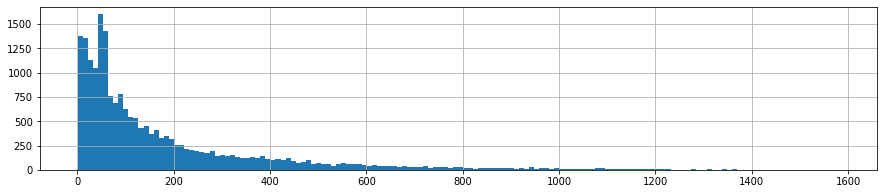

In [36]:
# check
data.days_exposition.hist(bins = 150, figsize = (15,3));

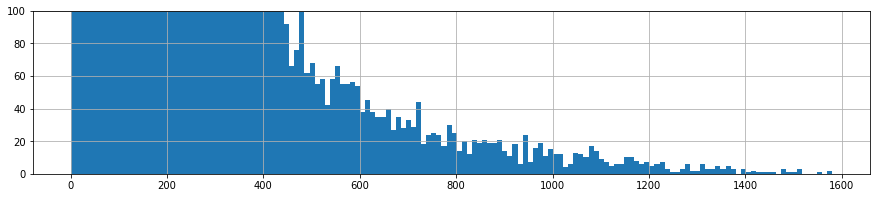

In [37]:
# check
data.days_exposition.hist(bins = 150, figsize = (15,3))
plt.ylim(0, 100);

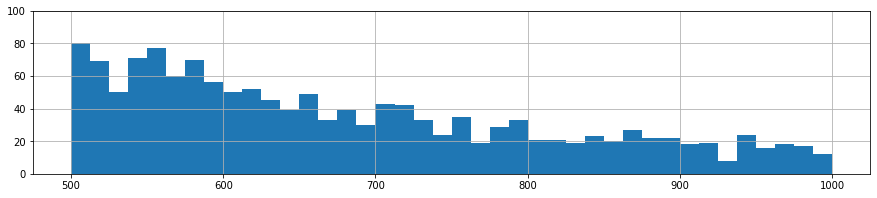

In [38]:
# check
data.days_exposition.hist(bins = 40, figsize = (15,3), range = (500,1000))
plt.ylim(0, 100);

In [39]:
# check
data[data.days_exposition > 1000]['days_exposition'].count()

264

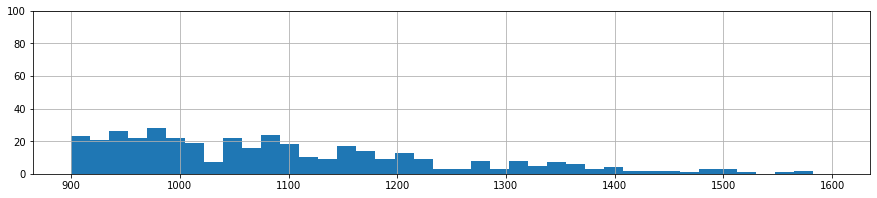

In [40]:
# check
data.days_exposition.hist(bins = 40, figsize = (15,3), range = (900,1600))
plt.ylim(0, 100);

In [41]:
# check
data = data[(data.days_exposition <= 1000) | (data.days_exposition.isna())]

In [42]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23037 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           23037 non-null  int64         
 1   last_price             23037 non-null  float64       
 2   total_area             23037 non-null  float64       
 3   first_day_exposition   23037 non-null  datetime64[ns]
 4   rooms                  23037 non-null  int64         
 5   ceiling_height         23037 non-null  float64       
 6   floors_total           23037 non-null  float64       
 7   living_area            23037 non-null  float64       
 8   floor                  23037 non-null  int64         
 9   is_apartment           2696 non-null   object        
 10  studio                 23037 non-null  bool          
 11  open_plan              23037 non-null  bool          
 12  kitchen_area           23037 non-null  float64       
 13  b

In [43]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,037.00","23,037.00","23,037.00","19,926.00","23,037.00","23,037.00","23,037.00","23,037.00","23,037.00"
min,0.00,12.00,2.00,1.00,"12,190.00",2.00,0.00,1.00,1.00
max,8.00,199.20,5.00,"1,000.00","330,000,000.00",164.70,132.30,27.00,29.00


### Провести анализ, зависимости стоимость от разных факторов

<font color='green'>
    Начнем с общей оценки данных, после наших изминений

In [44]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_to_total_ratio,price_metr,day_of_the_week_exp,year_exp
count,23037.000000,2.303700e+04,23037.000000,23037.000000,23037.000000,23037.000000,23037.000000,23037.000000,23037.000000,23037.000000,...,17581.000000,17582.000000,7762.000000,17582.000000,8698.000000,19926.000000,23037.000000,2.303700e+04,23037.000000,23037.000000
mean,9.871728,5.989594e+06,57.950111,2.029995,2.691093,10.683683,33.258467,5.875071,22.222480,0.596996,...,14290.247540,0.602776,490.750837,0.754806,523.501495,166.426428,0.564770,9.826174e+04,2.568564,2017.402396
std,5.665810,6.212128e+06,26.296133,0.990278,0.206048,6.538358,17.453833,4.849293,10.743772,0.962225,...,8571.534061,0.793215,338.839496,0.928720,277.327051,186.905463,0.102486,4.562950e+04,1.790113,1.005796
min,0.000000,1.219000e+04,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.021583,1.118349e+02,0.000000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,15.390000,0.000000,...,9481.000000,0.000000,288.000000,0.000000,301.000000,44.000000,0.491329,7.638889e+04,1.000000,2017.000000
50%,9.000000,4.600000e+06,51.400000,2.000000,2.650000,9.000000,30.000000,4.000000,19.800000,0.000000,...,13164.000000,0.000000,456.000000,0.000000,509.000000,92.000000,0.571429,9.478673e+04,3.000000,2017.000000
75%,14.000000,6.650000e+06,68.300000,3.000000,2.700000,16.000000,42.000000,8.000000,25.830000,1.000000,...,16293.000000,1.000000,613.000000,1.000000,733.000000,219.000000,0.633136,1.137389e+05,4.000000,2018.000000
max,50.000000,3.300000e+08,199.200000,8.000000,5.000000,29.000000,164.700000,27.000000,132.300000,5.000000,...,65952.000000,3.000000,3190.000000,3.000000,1344.000000,1000.000000,1.000000,1.736842e+06,6.000000,2019.000000


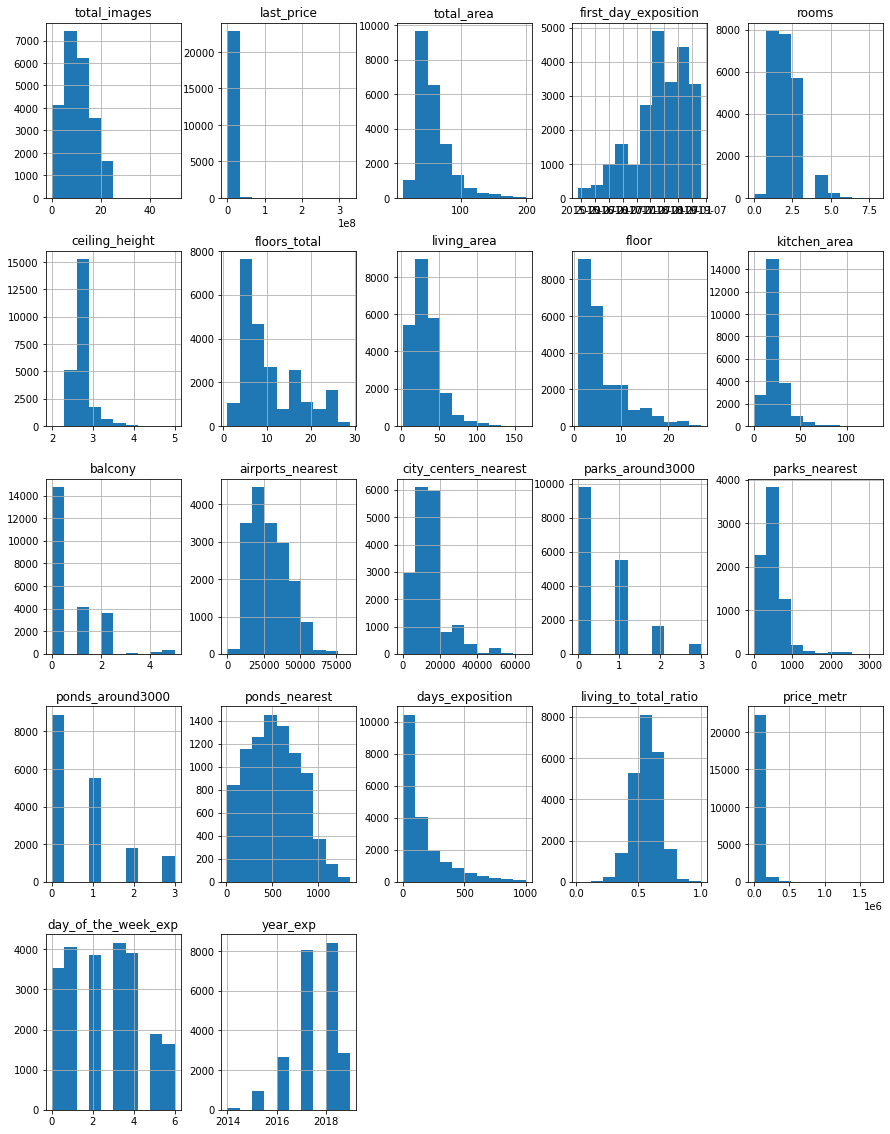

In [45]:
data.hist(figsize=(15, 20));

Первичные выводы:
 - Количество объявлений с годами стало больше, основной рост идет с 2017 года
 - Основные показатели недвижимости, растояние до цента до 20 км ( в основном большие города), в основном продают квартиры с 1-3 комнатами и без балкона
 - Отдельно надо изучить количество дней в продаже, проверить зависимость от факторов расположения и цены.
 - Дополнительной очиски требуеют данные по кол-ву комнат( 19 комнат это перебор) , этажность зданий.

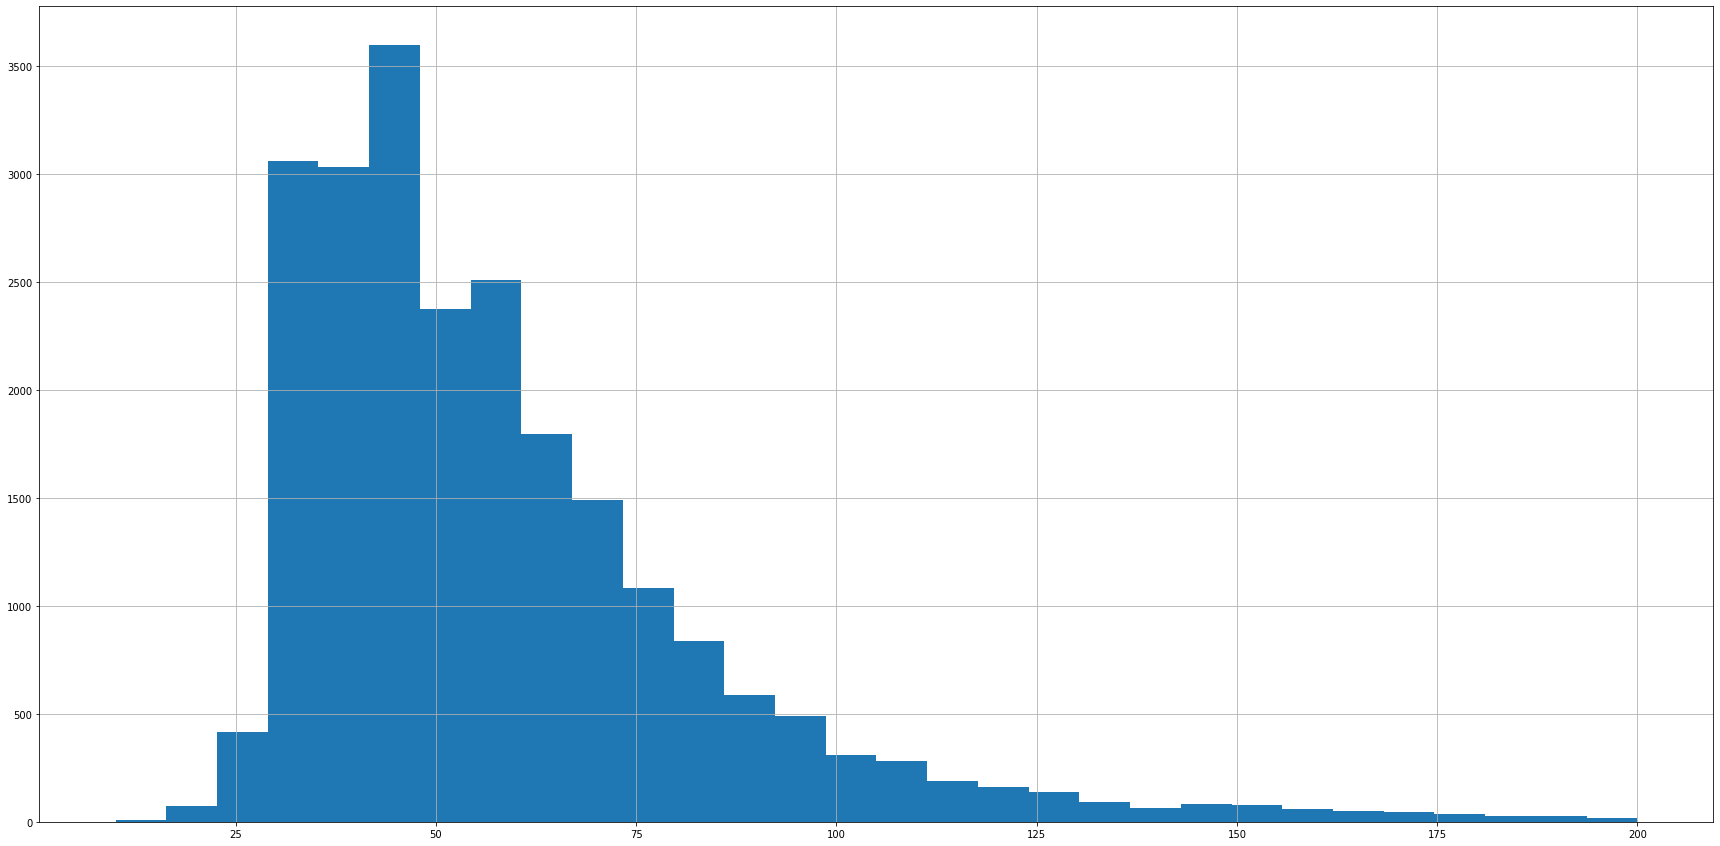

In [46]:
data['total_area'].hist(range = (10,200), bins = 30, figsize = (30,15))
plt.show()

Основные данные ледать в диапазоне от 20 до 200, остальное можно считать выбросами

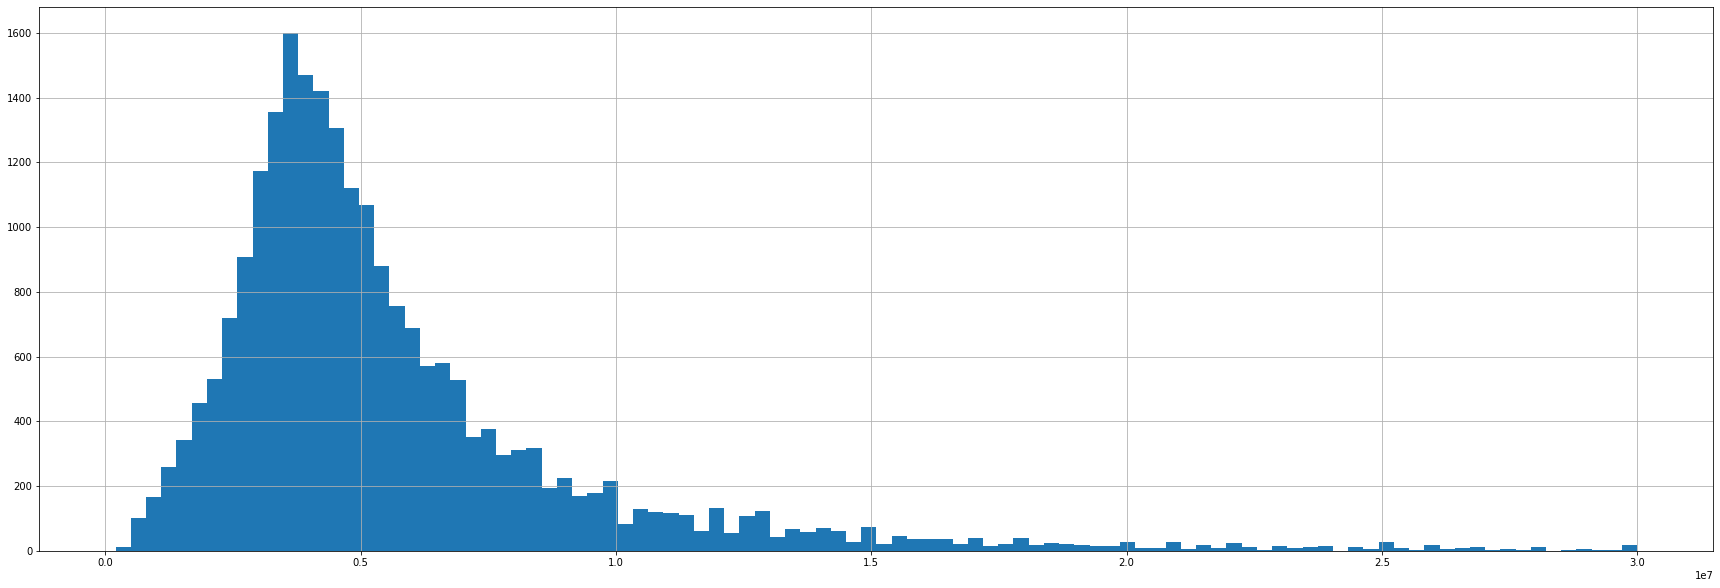

In [47]:
data['last_price'].hist(range = (200000, 30000000 ),bins = 100, figsize = (30,10))
plt.show()

Основной пик объявление приходится на 400.000 ( для Петербурга как то странно )

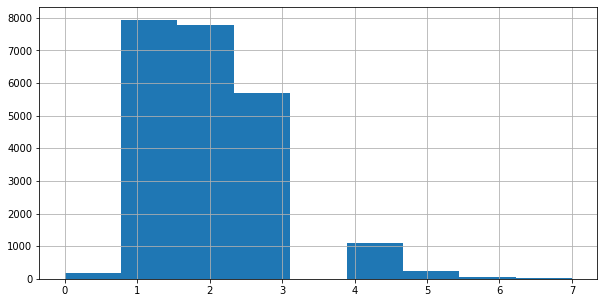

In [48]:
data['rooms'].hist(range = (0,7), bins = 9, figsize = (10,5))
plt.show()

В основном квартиры в диапазоне от 1 до 3 комнат ( видимо мода на студии, еще не пришла)

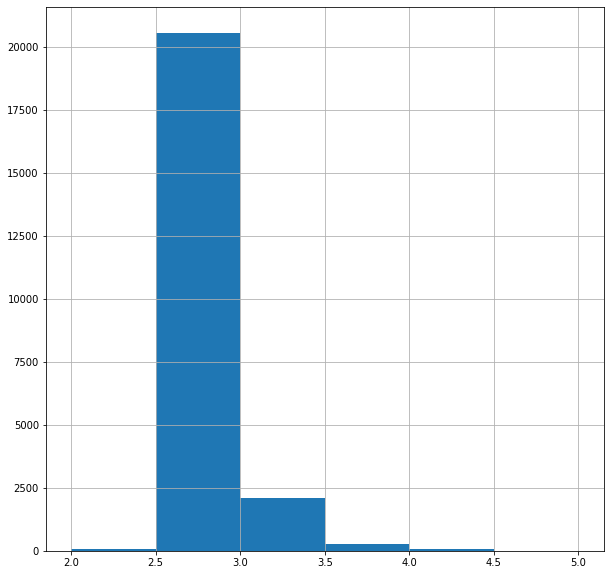

In [49]:
data['ceiling_height'].hist(range = (2,5), bins = 6, figsize = (10,10))
plt.show()

потолки по госту, 2.5 - 3.5 

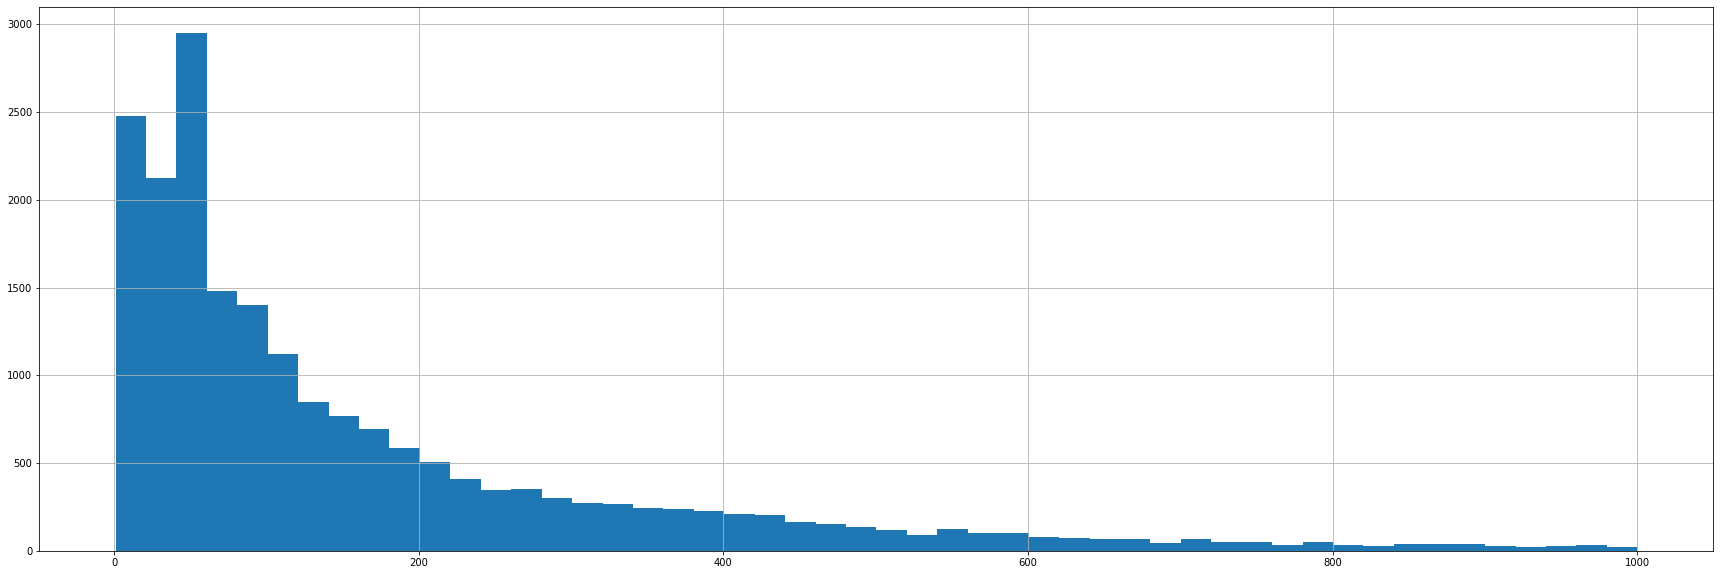

In [50]:
data['days_exposition'].hist(bins = 50, figsize = (30,10))
plt.show()

Быстрая продажа до 100 дней
Средняя продажа до 200 дней
Долгая продажа от 200 дней

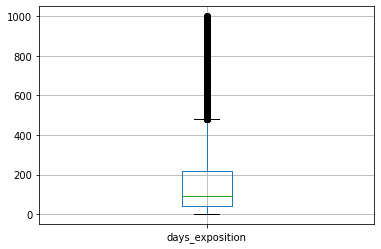

In [51]:
data.boxplot(column = 'days_exposition')
plt.show()

Коробочка в диапазоне от 100 до 200 дней, сверх 600 дней это уже выбросы

In [52]:
data['days_exposition'].describe()
#data['days_exposition'].hist()

count    19926.000000
mean       166.426428
std        186.905463
min          1.000000
25%         44.000000
50%         92.000000
75%        219.000000
max       1000.000000
Name: days_exposition, dtype: float64

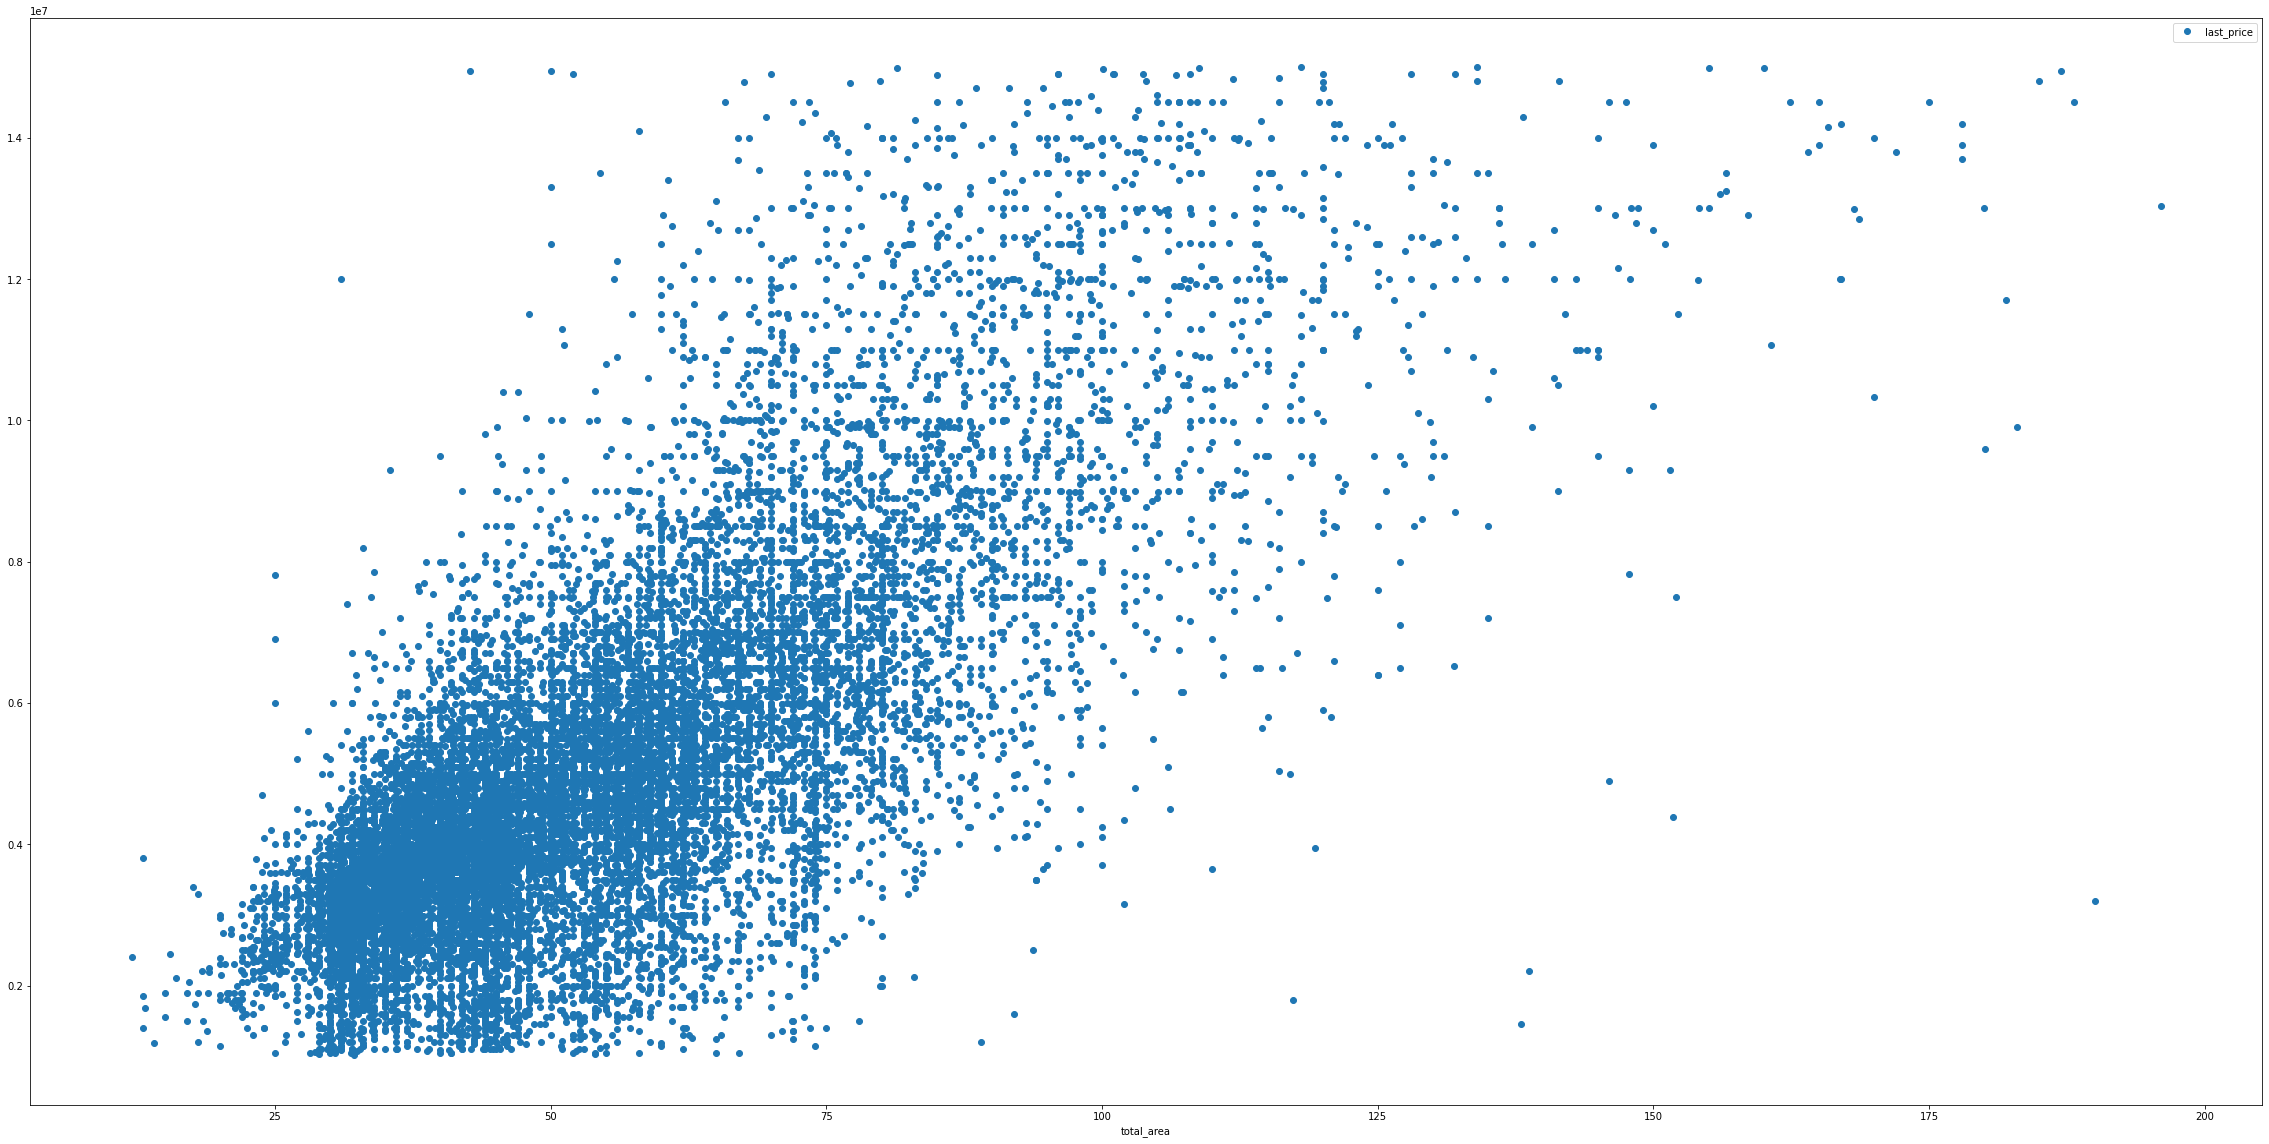

In [53]:
#Сделаем обрезку для укрупнения
data_query = data.query('(1000000<last_price < 15000000 and days_exposition<600 ) and (total_area<200 and rooms<=6)')
#выведем зависимость площади кв и цены
data_query.plot( x = 'total_area', y = 'last_price', style = 'o', figsize=(40,20))
plt.show()

Выводы о сроках продаж:
- Средняя продажа наблюдается в 180 дней ( 6 месяцев ), скорее всего надо разделить продажу на города, от этого значение может сильно измениться
- медиана выглядит более провдаподобно, 1.5 месяца хорошая скорость продажи ( при условии что у нас бошество объявленией это квартиры от 1 до 3 комнат)
- Верхняя граница кажеться немного черезмерной 230 дней ( но тут скорее всего есть выбросы со сверх долгими продажами)

In [54]:
data.sort_values(by='days_exposition', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,living_to_total_ratio,price_metr,day_of_the_week_exp,month_exp,year_exp,floor_group,city_centers_1km
23508,7,6100000.0,42.0,2015-02-19,1,2.80,10.0,14.0,9,NaN,...,3.0,153.0,1000.0,0.333333,145238.095238,3,February,2015,другой,7
6520,5,3900000.0,40.0,2014-12-24,1,2.50,12.0,20.0,7,False,...,0.0,NaN,1000.0,0.500000,97500.000000,2,December,2014,другой,5
3293,7,6850000.0,75.0,2015-03-09,3,3.30,5.0,54.7,5,False,...,0.0,NaN,999.0,0.729333,91333.333333,0,March,2015,последний,7
1566,15,16000000.0,110.0,2016-02-27,4,3.35,5.0,76.2,3,NaN,...,0.0,NaN,998.0,0.692727,145454.545455,5,February,2016,другой,15
15682,20,4650000.0,33.6,2015-03-10,1,2.65,13.0,17.1,10,NaN,...,2.0,359.0,998.0,0.508929,138392.857143,1,March,2015,другой,20
8818,9,4300000.0,40.6,2016-03-28,1,2.70,16.0,20.1,2,NaN,...,1.0,1015.0,996.0,0.495074,105911.330049,0,March,2016,другой,9
14856,20,4500000.0,46.1,2015-05-17,2,2.65,9.0,28.6,9,NaN,...,1.0,441.0,994.0,0.620390,97613.882863,6,May,2015,последний,20
23046,6,5200000.0,36.0,2016-08-02,1,2.65,25.0,15.3,16,NaN,...,1.0,333.0,993.0,0.425000,144444.444444,1,August,2016,другой,6
201,5,10880000.0,123.1,2015-11-12,6,3.20,5.0,89.0,2,NaN,...,0.0,NaN,992.0,0.722989,88383.428107,3,November,2015,другой,5
4803,9,4000000.0,60.4,2016-03-23,1,3.00,4.0,19.7,4,NaN,...,NaN,NaN,991.0,0.326159,66225.165563,2,March,2016,последний,9


In [55]:
# Основные статистики по годам
data.groupby('year_exp')['days_exposition'].describe()
# Оказывается самые долги продажи были в 2014- 2015 году

,count,mean,std,min,25%,50%,75%,max
year_exp,,,,,,,,
2014,69.0,704.202899,141.627575,554.0,583.00,649.0,831.0,1000.0
2015,879.0,536.769056,221.053051,182.0,349.50,503.0,703.5,1000.0
2016,2615.0,314.182792,245.938893,3.0,114.00,232.0,469.5,998.0
2017,7805.0,158.563613,152.758259,3.0,45.00,103.0,226.0,814.0
2018,7486.0,93.973417,84.850496,3.0,34.00,63.0,130.0,465.0
2019,1072.0,30.915112,23.881072,1.0,11.75,23.0,45.0,110.0


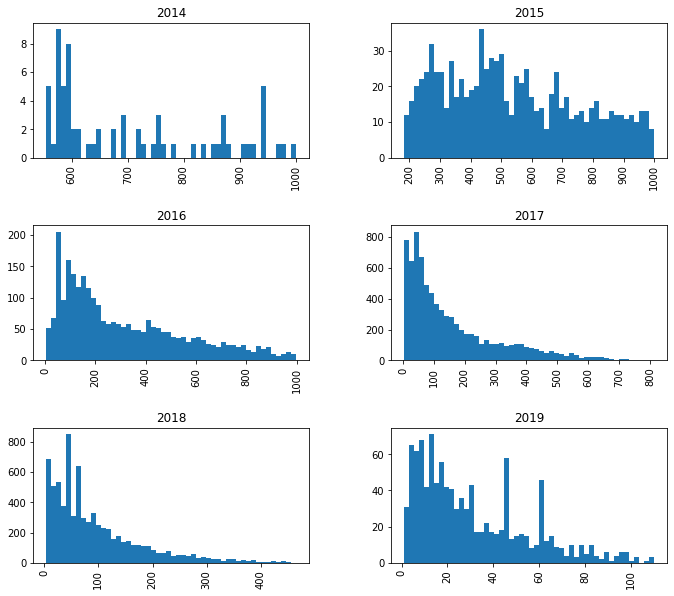

In [56]:
# Гистограммы для каждого года
data.hist(column='days_exposition', by='year_exp', figsize=(11, 10), bins=50);

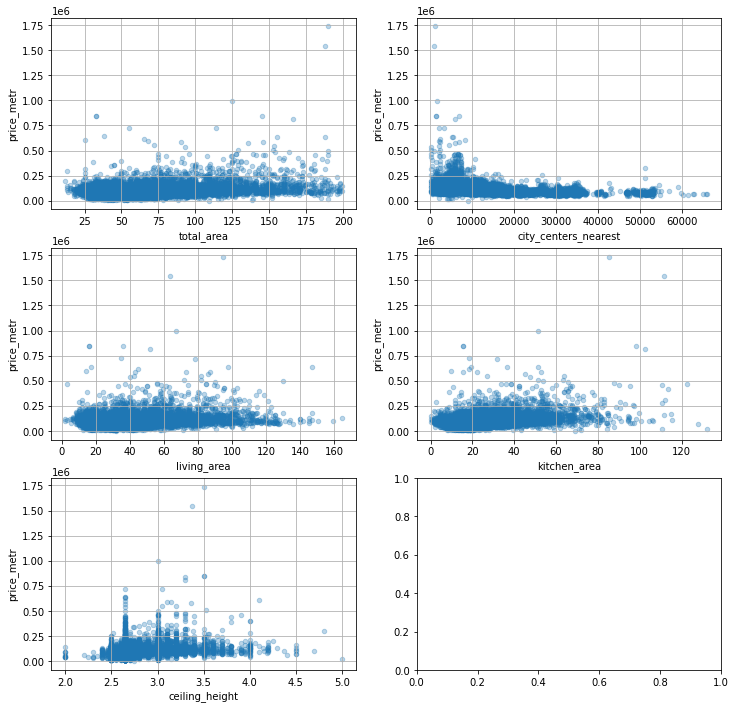

In [57]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(3, 2)
# Создание массива с параметрами
num_columns = ['total_area', 'city_centers_nearest', 'living_area', 'kitchen_area', 'ceiling_height']

# Отрисовка диаграмм рассеяния, отражающих связь параметров и цены за кв. метр
for i in range(len(num_columns)):
    (
        data.plot(kind='scatter', x=num_columns[i], y='price_metr', grid=True, ax=axes[i//2, i%2], figsize=(12, 12), alpha=0.3)
    )

In [58]:
data['last_price'].corr(data['total_area'])
#НАибольшая кореляция между ценой и общей площадью

0.6565877928917686

In [59]:
data['last_price'].corr(data['rooms'])
# А зависимости с количеством комная почти нет

0.37745930812323375

In [60]:
good_corr = (
    data.
    pivot_table(index='last_price', values=['total_area', 'living_area', 'kitchen_area', 'rooms'])
    )
print(good_corr.corr())

              kitchen_area  living_area     rooms  total_area
kitchen_area      1.000000     0.691329  0.618493    0.892347
living_area       0.691329     1.000000  0.879413    0.943024
rooms             0.618493     0.879413  1.000000    0.834156
total_area        0.892347     0.943024  0.834156    1.000000


<AxesSubplot:xlabel='floor_group'>

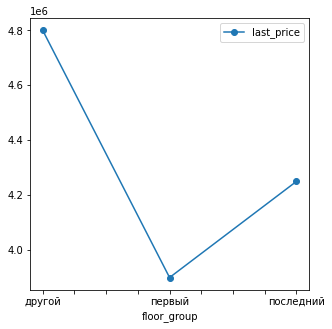

In [61]:
data.pivot_table(index = 'floor_group', values = 'last_price', aggfunc = 'median').plot(style='o-', figsize=(5, 5))

# На удивление квартиры на 1 этаже не пользуются спросом

<AxesSubplot:xlabel='day_of_the_week_exp'>

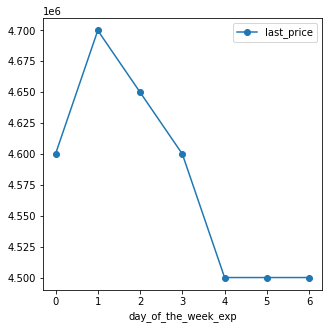

In [62]:
data.pivot_table(index = 'day_of_the_week_exp', values = 'last_price', aggfunc = 'median').plot(style='o-', figsize=(5, 5))
# Видимо все мы начинаем жизнь заново по понедельника, сновной пик размещений идет в начале недели

<AxesSubplot:xlabel='month_exp'>

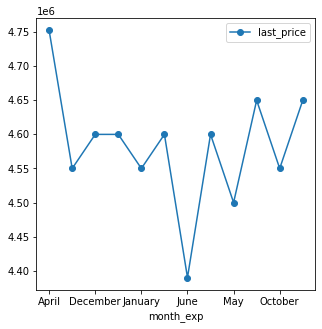

In [63]:
data.pivot_table(index = 'month_exp', values = 'last_price', aggfunc = 'median').plot(style='o-', figsize=(5, 5))
# пиковые размещения идут в апреле, а минимальные в июне (отпуска, куда без них)

<AxesSubplot:xlabel='year_exp'>

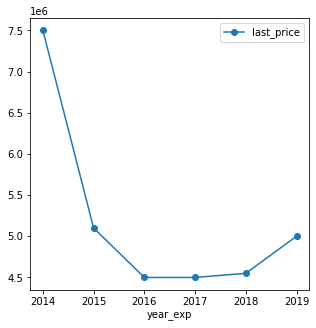

In [64]:
data.pivot_table(index = 'year_exp', values = 'last_price', aggfunc = 'median').plot(style='o-', figsize=(5, 5))
# кризис 14 года сделал свое дело, восстановление началось только после 18

In [65]:
# Найдем населенные пункты с наибольшим количеством объявлений и среднюю цену
ten_city = data['locality_name'].value_counts().head(10)
price_top10 = data.query('locality_name in @ten_city.index').pivot_table(index = 'locality_name', values = 'price_metr', aggfunc = 'mean')
price_top10 = price_top10.astype(int)
price_top10.sort_values(by = 'price_metr', ascending = False)


,price_metr
locality_name,
Санкт-Петербург,113442
Пушкин,103167
деревня Кудрово,92421
поселок Парголово,90259
поселок Мурино,85737
поселок Шушары,78488
Колпино,75279
Гатчина,68746
Всеволожск,68699


~ Как и ожидалось, самый дорогой метр в Санк-Петербурге 114868, а самый доступный Выборг 58141



Создадим в таблице столбец с расстоянием до центра в километрах, округлим его до целых значений

In [66]:
# посчитаем среднюю цену для каждого километра.
data['price_1km'] = data['last_price'] / data['city_centers_nearest'].dropna().astype(int)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,living_to_total_ratio,price_metr,day_of_the_week_exp,month_exp,year_exp,floor_group,city_centers_1km,price_1km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,755.0,NaN,0.472222,120370.370370,3,March,2019,другой,20,811.080609
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,NaN,81.0,0.460396,82920.792079,1,December,2018,первый,7,180.078482
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,574.0,558.0,0.612500,92785.714286,3,August,2015,другой,10,372.927582
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,100.435000,9,NaN,...,234.0,424.0,0.631667,408176.100629,4,July,2015,другой,0,9544.117647
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,48.0,121.0,0.320000,100000.000000,1,June,2018,другой,2,1234.872808
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,NaN,...,NaN,55.0,0.473684,95065.789474,0,September,2018,другой,10,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,NaN,...,NaN,155.0,0.284182,99195.710456,3,November,2017,другой,6,193.282140
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,41.886654,22,NaN,...,NaN,NaN,0.585009,110544.692737,3,April,2019,другой,5,680.333505
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.430000,26,NaN,...,NaN,189.0,0.465320,87454.764777,2,May,2018,другой,20,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,NaN,...,NaN,289.0,0.714754,88524.590164,6,February,2017,другой,18,359.808102


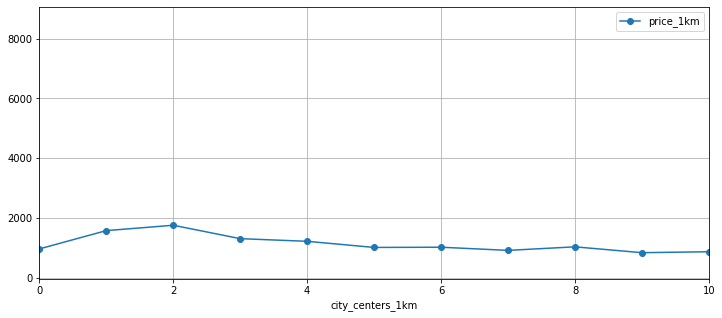

In [67]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='city_centers_1km', values='price_1km').plot(grid=True, style='o-', xlim=(0,10), figsize=(12, 5))
plt.show()

Выводы:
 - Самые дорогие квариты находятся в центре, главный пик до 1 км
 - После 2 км стоимость сглаживается

### Заключение и общий вывод

После продаланного исследования можно сказать:
 - Главыные факторы которые влияют на стоимость квартиры расположение от центра (самые высокая цена до 2 км)
 - Основные факторы цены это общая площадь, кол-во комнат и не первый этаж.
 - Максимальныи спроссом пользуются крупные города (и кол-во объявлений и стоимость метра), но есть и исключения (деревня Кудрово ТОП 3)
 - Средняя срок продажи в 180 дней ( 6 месяцев ) ( но тут надо, очистить данные на города и иные населенные пункты )

### Бонус

In [68]:
# check
import seaborn as sns

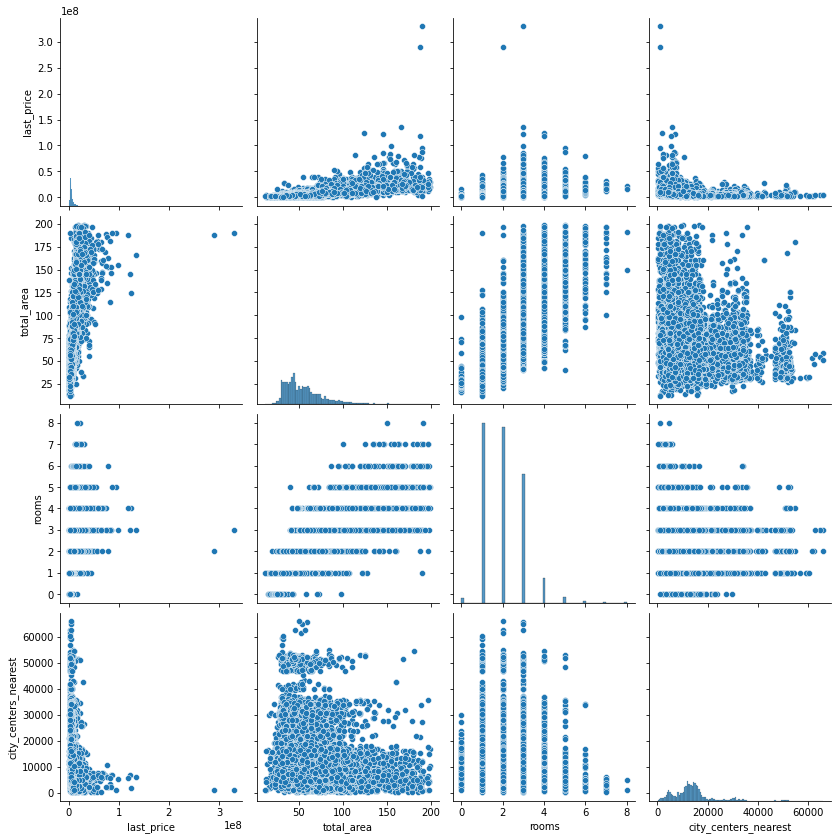

In [69]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'city_centers_nearest']])
plt.gcf().set_size_inches(12,12);


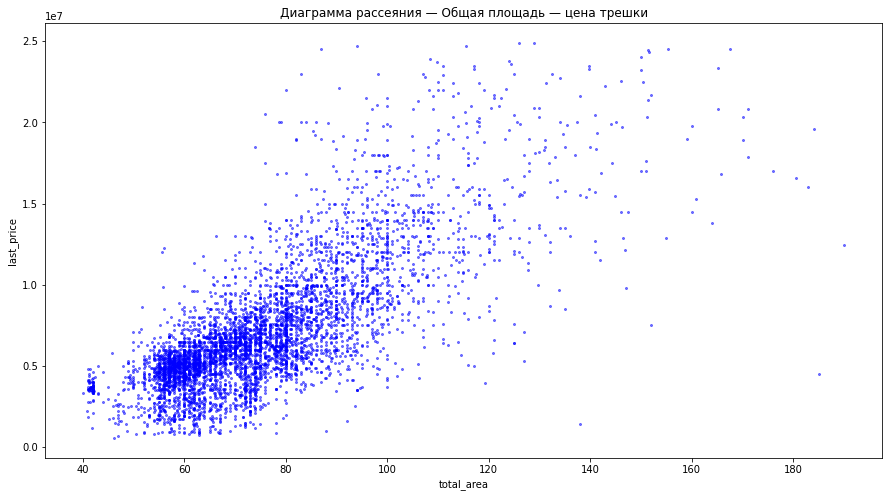

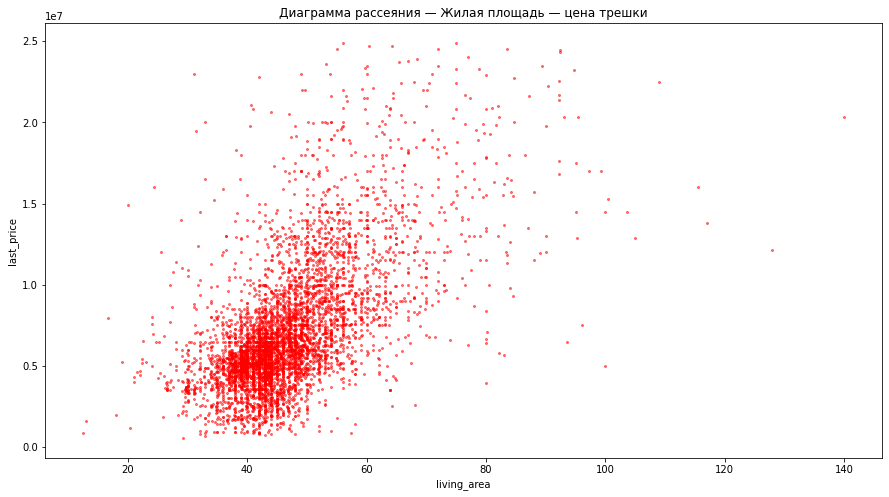

In [70]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

In [71]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check.query('airports_nearest.isna() | airports_nearest < 60000')
df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [72]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check[(df_check ['airports_nearest'] < 60000) | (df_check ['airports_nearest'].isna()) ]

df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   